In [1]:
from build_events import *
from preclustering import *
from light import *
import h5py
import fire
import time
import os
from tqdm import tqdm
from adc64format import dtypes, ADC64Reader

In [2]:
import plotly

In [3]:
dict_path = 'layout/multi_tile_layout-2.3.16.pkl'
pixel_xy = load_geom_dict(dict_path)
print('Using pixel layout dictionary: ', dict_path)

Using pixel layout dictionary:  layout/multi_tile_layout-2.3.16.pkl


In [4]:
input_packets_filename = '/sdf/group/neutrino/sfogarty/module0_files/charge_data/datalog_2021_04_04_00_41_40_CEST.h5'
print('Opening packets file: ', input_packets_filename)
f_packets = h5py.File(input_packets_filename)

Opening packets file:  /sdf/group/neutrino/sfogarty/module0_files/charge_data/datalog_2021_04_04_00_41_40_CEST.h5


In [5]:
mc_assn=None
try:
    mc_assn = f_packets['mc_packets_assn']
except:
    mc_assn=None
    print("No 'mc_packets_assn' dataset found, processing as real data.")

No 'mc_packets_assn' dataset found, processing as real data.


In [6]:
packets = f_packets['packets']
PPS_indices = np.where((packets['packet_type'] == 6) & (packets['trigger_type'] == 83))[0]

In [7]:
np.sum(packets['packet_type'] == 7)

72793

In [8]:
nSec_end = 80
nSec_start = 60

print('Processing the first '+ str(nSec_end - nSec_start) + ' seconds of data, starting at '+\
     str(nSec_start) + ' seconds and stopping at ', str(nSec_end) + ' ...')
for sec in tqdm(range(nSec_start,int(nSec_end)+1),desc=" Seconds Processed: "):
    # grab 1s at a time to analyze, plus the next 1s 
    if sec == 1:
        packets_1sec = packets[0:PPS_indices[sec-1]]
        packets_nextPPS = packets[PPS_indices[sec-1]:PPS_indices[sec]]
        if mc_assn != None:
            mc_assn_1sec = mc_assn[0:PPS_indices[sec-1]]
            mc_assn_nextPPS = mc_assn[PPS_indices[sec-1]:PPS_indices[sec]]
    elif sec >= nSec_start and sec <= nSec_end:
        packets_1sec = packets[PPS_indices[sec-2]:PPS_indices[sec-1]]
        packets_nextPPS = packets[PPS_indices[sec-1]:PPS_indices[sec]]
        if mc_assn != None:
            mc_assn_1sec = mc_assn[PPS_indices[sec-2]:PPS_indices[sec-1]]
            mc_assn_nextPPS = mc_assn[PPS_indices[sec-1]:PPS_indices[sec]]

    # remove packets from the 1sec that belongs in the previous second
    packets_1sec_receipt_diff_mask = (packets_1sec['receipt_timestamp'].astype(int) - packets_1sec['timestamp'].astype(int) < 0)\
            & (packets_1sec['packet_type'] == 0)
    packets_1sec = packets_1sec[np.invert(packets_1sec_receipt_diff_mask)]

    # move packets from nextPPS to 1sec that belong 1sec earlier
    packets_nextPPS_receipt_diff_mask = (packets_nextPPS['receipt_timestamp'].astype(int) - packets_nextPPS['timestamp'].astype(int) < 0) \
            & (packets_nextPPS['packet_type'] == 0)
    # move those packets from nextPPS to 1sec. Now we will only work on packets_1sec
    packets_1sec = np.concatenate((packets_1sec, packets_nextPPS[packets_nextPPS_receipt_diff_mask]))
    if mc_assn != None:
        mc_assn_1sec = mc_assn_1sec[np.invert(packets_1sec_receipt_diff_mask)]
        mc_assn_1sec = np.concatenate((mc_assn_1sec, mc_assn_nextPPS[packets_nextPPS_receipt_diff_mask]))
    else:
        mc_assn_1sec = None
    if sec == nSec_start:
        results_small_clusters, results_large_clusters, unix_pt7, PPS_pt7 = analysis(packets_1sec, pixel_xy, mc_assn_1sec)
    elif sec > nSec_start:
        results_small_clusters_temp, results_large_clusters_temp, unix_pt7_temp, PPS_pt7_temp = analysis(packets_1sec, pixel_xy, mc_assn_1sec)
        results_small_clusters = np.concatenate((results_small_clusters, results_small_clusters_temp))
        results_large_clusters = np.concatenate((results_large_clusters, results_large_clusters_temp))
        unix_pt7 = np.concatenate((unix_pt7, unix_pt7_temp))
        PPS_pt7 = np.concatenate((PPS_pt7, PPS_pt7_temp))

Processing the first 20 seconds of data, starting at 60 seconds and stopping at  80 ...


 Seconds Processed: 100%|██████████| 21/21 [00:13<00:00,  1.60it/s]


In [10]:
print('Loading light files with a batch size of ', batch_size, ' ...')
light_events_all = read_light_files(0, nSec_end)

Loading light files with a batch size of  50  ...


Seconds processed in the light data:: 81it [00:47,  1.71it/s]                        

Finished reading light data.


In [11]:
light_events_all = light_events_all[light_events_all['unix'] != 0]
matched_triggers, indices_in_ext_triggers = match_to_ext_trigger(light_events_all, PPS_pt7, unix_pt7)
evt_mask = indices_in_ext_triggers != -1
indices_in_ext_triggers = indices_in_ext_triggers[evt_mask]
light_events_all = light_events_all[evt_mask]
PPS_pt7_light = PPS_pt7[indices_in_ext_triggers]

# match ext triggers / light events to charge events
#match_light_to_charge(light_events_all, results_small_clusters, PPS_pt7_light)

 Matching light triggers to packets: 100%|██████████| 7814/7814 [00:00<00:00, 26221.87it/s]


Total matched triggers =  3830  out of  3850  total triggers.
Total matched triggers based on unix only =  3850  out of  3850  total triggers.
Total matched triggers based on PPS only =  3830  out of  3850  total triggers.
charge event ns =  [725634375 725638437 141894375 725662500 469732500 390450000 874793125
 814818750 632912500 725952500 433875000 141327500 189178125 220445000
 409629375 365232500 434343125 329404375 220448125 662394375 195842500
 762548750 773772500 752195000 141472500 434325000 220446875 654305937
 354548750 434335625 999065000 816720625 487727500 121913125 195840625
 149520000 220449375 509959375 370857187 434373125 181634375 141440000
 141486250 391914375 773791875 783978750 195832500 618183750 395596875
 489452500]
charge event ns max =  1618648750
PPS_ext_triggers =  [1.736220e+07 2.222310e+07 4.607750e+07 4.989840e+07 5.956160e+07
 6.703610e+07 6.881120e+07 7.172810e+07 8.121370e+07 8.443800e+07
 8.733010e+07 9.003450e+07 9.121080e+07 9.316430e+07 9.317710e+

 Matching light events to charge events: 100%|██████████| 1890/1890 [00:00<00:00, 2175.86it/s]

Number of 0, 1, 2, 3, or >3 matches:  203   0   1   1   1685


In [43]:
charge_events = results_small_clusters
light_events = light_events_all
PPS_ext_triggers = PPS_pt7

charge_event_ns = charge_events['t']
num_matched_0 = 0
num_matched_1 = 0
num_matched_2 = 0
num_matched_3 = 0
num_matched_more = 0
#print('charge event ns = ', charge_event_ns[0:50])
#print('charge event ns max = ', np.max(charge_event_ns))
#print('PPS_ext_triggers = ', PPS_ext_triggers[0:50])
PPS_window = int(drift_distance / v_drift * 1e3)
print('PPS_window = ', PPS_window)
# loop through light events and check for charge event within a drift window
"""
for i in tqdm(range(len(light_events)), desc = ' Matching light events to charge events: '):
    light_event = light_events[i]
    PPS_ext_trigger = PPS_ext_triggers[i]
    matched_events = (charge_event_ns > PPS_ext_trigger) & (charge_event_ns < PPS_ext_trigger + PPS_window)
    matched_events_indices = np.where(matched_events)[0]
    if len(matched_events_indices) == 0:
        num_matched_0 += 1
    elif len(matched_events_indices) == 1:
        num_matched_1 += 1
    elif len(matched_events_indices) == 2:
        num_matched_2 += 1
    elif len(matched_events_indices) == 3:
        num_matched_3 += 1
    elif len(matched_events_indices) > 3:
        num_matched_more += 1
print('Number of 0, 1, 2, 3, or >3 matches: ', num_matched_0,' ', num_matched_1, ' ',num_matched_2,' ', num_matched_3,' ', num_matched_more)
"""
i = 509
light_event = light_events[i]
PPS_ext_trigger = PPS_ext_triggers[i]
matched_events = (charge_event_ns > PPS_ext_trigger) & (charge_event_ns < PPS_ext_trigger + PPS_window)
matched_events_indices = np.where(matched_events)[0]
print(len(matched_events_indices))
print(charge_events['x'][matched_events_indices])
print(charge_events['y'][matched_events_indices])
print(charge_events['z'][matched_events_indices])


PPS_window =  189187
28
[  -6.   -6.    0.  -77. -104.  -24.  -33.  -86.  -82. -285.  108.   95.
   37.   28.   55.  228.  -86.  108.  -46.  -50.  -99.  232.  232.   86.
  308.  303.  166.  290.]
[-454.          180.83333333    0.         -215.         -317.
   95.           50.         -239.         -215.         -445.
  614.          547.          379.          348.          432.
 -427.         -465.           42.          201.          379.
  427.         -614.         -614.         -259.         -569.
 -454.         -379.         -361.        ]
[ 304.  304.    0. -304. -304. -304. -304. -304. -304.  304.  304.  304.
  304.  304.  304.  304. -304. -304.  304. -304. -304.  304.  304. -304.
 -304. -304. -304. -304.]


In [62]:
t_for_plot = charge_events[charge_events['t'] <= 1000000000]['t']
tmax = 1000000000
tmin = 0
bins = 5350
binsize = (tmax - tmin)/bins 

#%matplotlib widget 
#plt.hist(t_for_plot, range=(tmin,tmax), bins = bins)
import plotly.graph_objs as go
trace = go.Histogram(x=t_for_plot, xbins=dict(start=tmin, end = tmax, size = (tmax-tmin)/bins))
fig = go.Figure(data=[trace])
fig.show()

(-600.0, 600.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
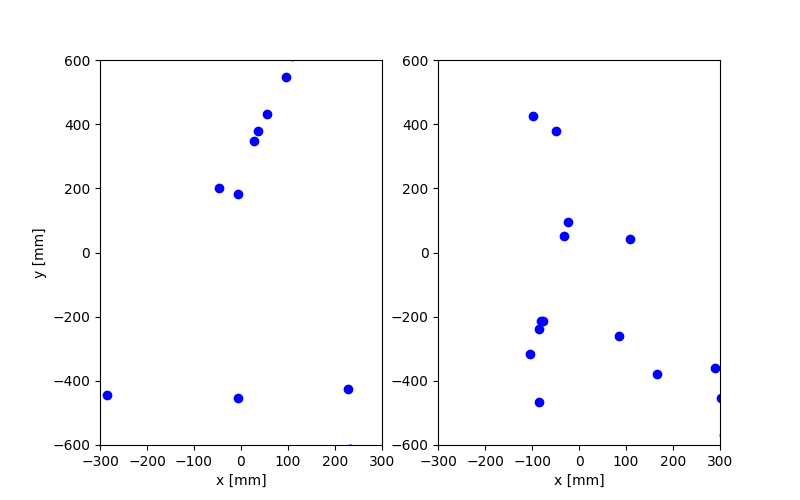

In [44]:
%matplotlib widget
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(8,5))
charge_events_sel = charge_events[matched_events_indices]
axes[0].plot(charge_events_sel[charge_events_sel['z'] > 0]['x'], charge_events_sel[charge_events_sel['z'] > 0]['y'], 'bo')
axes[1].plot(charge_events_sel[charge_events_sel['z'] < 0]['x'], charge_events_sel[charge_events_sel['z'] < 0]['y'], 'bo')
#axes[0].set_title('io group 1')
#axes[1].set_title('io_group 2')
#fig.suptitle(r'$^{39} Ar$ $\beta-$ candidates spatial distribution (module-0 data)')
axes[0].set_xlabel('x [mm]')
axes[1].set_xlabel('x [mm]')
axes[0].set_ylabel('y [mm]')
axes[0].set_xlim(-300, 300)
axes[0].set_ylim(-600, 600)
axes[1].set_xlim(-300, 300)
axes[1].set_ylim(-600, 600)

In [12]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(0,len(events_314C_all['tai_ns']),1), y=events_314C_all['tai_ns']))
fig.show()